<a href="https://colab.research.google.com/github/ds4ph-bme/prelab3-bbains31/blob/main/prelab3_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prelab 3: Introduction to optimization with PyTorch

By **Benjamín Béjar Haro** and **Kwame Kutten**

In this prelab we will learn how to implement gradient descent for finding local minima of a given cost function. This will provide us with a basic tool for many machine learning and classification problems since, at the end of the day, finding a classifier amounts to solving some optimization problem. In this lab we will also learn how gradient descent
can be implemented using [PyTorch](https://pytorch.org/tutorials/), a scientific library for developing machine (deep) learning methods. Towards that goal, we will be learning a [linear classifier](https://en.wikipedia.org/wiki/Linear_classifier) on the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) digit dataset. As a loss function, we will be using a simple quadratic function. You will first apply your calculus skills to the problem, and analytically solve it. Then you will learn how to solve the same problem by implementing the gradient descent method and applying it to the cost function. Finally, you will learn the basics of PyTorch by using the built-in functions to train the classifier. This pre-lab assignment needs to be solved in this Notebook.

## The data
The MNIST database consists of $28\times 28$ grayscale images of handwritten digits, along with the correct label for each image. These are in the form of $28\times 28$ matrices with the value of each index being an 8-bit integer ranging from 0 (black) to 255 (white), and one integer between 0 and 9, corresponding to the digit displayed in the image. The database is split into two separate training and testing sets.


## Problem description
We are given a set of $N$ feature-label pairs $\big\{\big(\boldsymbol x_i,c_i\big)\big\}_{i=0}^{N-1}$ where each $\boldsymbol x_i\in\mathbb{R}^p$ corresponds to a vectorized $28\times28$ grayscale image of a digit, and $c_i\in \{0,1,\ldots,9\}$ is the digit's class. Thus for this dataset the feature vector length is $p = 28\times 28 = 784$ and there are $n=10$ categories. Since we are dealing with a multi-class classification problem we will encode each digit's class with a one-hot embedding vector as:
$$\boldsymbol y_i = \begin{bmatrix}
y_{i0} \\
\vdots \\
y_{i9}
\end{bmatrix},\quad y_{ij} = \begin{cases}1 &c_i = j\\0&\textrm{else}\end{cases}.$$
The goal is then to find a prediction function $f:\mathbb{R}^p\mapsto\{0,1\}^n$ that maps features $\boldsymbol x_i$ (images) to labels $\boldsymbol y_i$. In order to do so, we will use a linear prediction function:

$$f(\boldsymbol x) = \boldsymbol W \boldsymbol x,\quad \boldsymbol W\in\mathbb{R}^{n\times p},$$
where the $j$th row of $\boldsymbol W$ represents a predictor for the $j$th class. In order to decide upon the estimated class we take the strongest response of our set of predictors, that is:
$$\widehat{c}_i = \arg\max_{j}\,\boldsymbol W\boldsymbol x_i.$$

## Problem formulation (optimization problem)
With all previous considerations in mind we can now define the optimization problem to estimate the parameters $\boldsymbol W$ of our linear predictor. In order to do that, we need to define some loss function on our predictions that penalizes deviations from the true target. For this problem, we will be using a simple quadratic loss function $L\big(f(\boldsymbol x),\boldsymbol y\big) = \lVert \boldsymbol y - f(\boldsymbol x)\rVert_2^2$. The goal is then to find the parameters $\boldsymbol W$ of our linear predictor function $f(\cdot)$ that minimize the average loss over the set of samples:
$$\min_{\boldsymbol W}\; \frac{1}{N}\sum_{i=0}^{N-1}\lVert \boldsymbol y_i - \boldsymbol W\boldsymbol x_i\rVert_2^2.$$
Note that the above optimization problem can be expressed in a compact form as:
$$\min_{\boldsymbol W}\; \frac{1}{N}\lVert \boldsymbol Y - \boldsymbol W\boldsymbol X\rVert_F^2,$$
where $\lVert\cdot\rVert_F$ is the Frobenius ($\ell_2$) norm of a matrix, and where the matrices $\boldsymbol Y=[\boldsymbol y_0,\ldots,\boldsymbol y_{N-1}]$ and $\boldsymbol X = [\boldsymbol x_0,\ldots,\boldsymbol x_{N-1}]$ consist of stacking the label and feature vector representations, respectively.

Given the feature and label matrices $\boldsymbol X\in\mathbb{R}^{p\times N}$ and $\boldsymbol Y\in\mathbb{R}^{n\times N}$, it can be shown that the closed-form solution for this optimization problem is

$$\boldsymbol W^\star = \boldsymbol Y \boldsymbol X^+$$

where $\boldsymbol X^+$ dentotes the [matrix pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of $\boldsymbol X$.

# Data loading and pre-processing

First we need to download the data and pre-process it. The MNIST database is very well known and available to download in PyTorch using a pre-defined function. Then, we scale and shift the images such that the value associated with each index lies between -1 and +1. Again, we can use pre-defined PyTorch transform functions to do so. This requires an extra step of casting the image to a `torch.Tensor` object. Tensors are multi-dimensional array objects that PyTorch uses as variables.

As usual, we start our Python code by importing the dependencies.  In Anaconda the `torch` and `torchvision` modules will be installed if they are not avialable.

In [14]:
# import modules here

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# inline plots for matplotlib
%matplotlib inline


try:
    import torch, torchvision
except:
    # Install packages if not available
    !conda install -y -c pytorch pytorch
    !conda install -y -c pytorch torchvision
    import torch, torchvision
import torchvision.transforms as transforms

# set the seed of PyTorch random number generator for reproducibility
torch.manual_seed(0)

# define transformation object to be applied to the data, list of transformations through Compose
# first convert to tensor
# then subtract 0.5 to every entry
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

Next, we use the `torchvision.datasets.MNIST` command to load the database. As the database is very large and contains more images than we require, we use the PyTorch [dataloader function](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to load a certain number of images, along with their labels, as local varables.  You may need to edit the `path` variable below if necessary.

In [15]:
# ============================================================================
# Edit path variable below if necessary
# ============================================================================
try:
    # Executes if running in Google Colab
    from google.colab import drive
    drive.mount("gdrive/")
    path = "gdrive/My Drive/" # Change path to location of data if necessary
except:
    # Executes if running locally (e.g. Anaconda)
    path = "./" # Change path to location of data if necessary

# Download the data if not already in the specified directory
trainset = torchvision.datasets.MNIST(path, train=True, transform=transform, download=True)
testset  = torchvision.datasets.MNIST(path, train=False, transform=transform, download=True)

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).


In [16]:
# specify the number of points to be extracted at every iteration
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000,shuffle=False) # 1000 images from the training set
testloader = torch.utils.data.DataLoader(testset, batch_size=100,shuffle=False)    #  100 images from the testing set

# create an iterator to return the data from the data loader
dataiter = iter(trainloader)
# loading the training data into the images and labels variables
images, labels = next(dataiter)

# similarly for the test data
test_dataiter = iter(testloader)
test_images, test_labels = next(test_dataiter)

In [17]:
# check the sizes to make sure you have done everything right:
print(images.shape) # you should get [10000,1,28,28]
print(labels.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


Now your data is in the `images` variable. Let's just display an example.

tensor(0.9843)


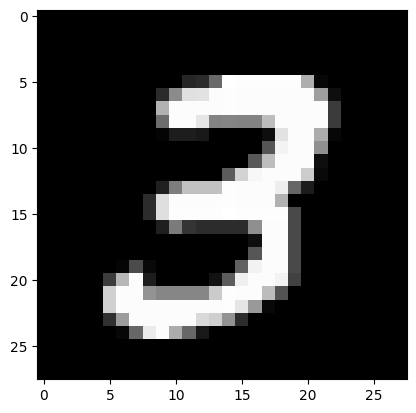

In [18]:
# choose an index
num_image = 7

# for displaying an image we need to convert the tensor to a numpy array
# the squeeze() function removes all redundant dimensions of the array i.e.,
# images[num_array] is a 1x1x28x28 array
plt.imshow(images[num_image].numpy().squeeze(), cmap='gray');

# maybe investigate the values:
print(images[1,0,22,10].squeeze())

In [19]:
print(images[1,0,0:5,0:5].squeeze())

tensor([[-1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.]])


**Exercise 1 [30 points total].**
 * Using the training data $X$ and the expression for the optimal predictor's weights, $W^\star =  Y X^+$,  compute the optimal predictor over the training data [12 points]
 * Then apply your predictor to the training and test dataset using $Y^\star = (W^\star) X$ and  $Y^\star_{\text{test}} = (W^\star) X_{\text{test}}$ respectively [12 points]
 * Report classification accuracy over both training and testing sets [6 points]

For a set of ground-truth labels $c_i$ and their corresponding estimates $\widehat{c}_i$, the __accuracy__ is defined as:

$$Acc = \frac{1}{N}\sum_{i=0}^{N-1}\mathbb{1}\big(c_i == \widehat{c}_i\big),\quad \mathbb{1}\big(z\big) = \begin{cases}1&z\; \textrm{is true}\\0 &\textrm{else}\end{cases}.$$

In [20]:
imageWidth = images.shape[2]
imageHeight = images.shape[3]
numTrainImages = images.shape[0]
numTestImages = test_images.shape[0]
p = imageWidth * imageHeight

N_train = numTrainImages
N_test = numTestImages

# Create X
X = images.view(N_train, p).numpy().T
X_test = test_images.view(N_test, p).numpy().T

# Normalize the data
X -= np.mean(X, axis=0)
X_test -= np.mean(X_test, axis=0)

#Hotencode labels of training set
encoder = OneHotEncoder(sparse_output=False)
Y_train = encoder.fit_transform(labels.reshape(-1,1)).T

#Prepare W*
X_inv = np.linalg.pinv(X)
W_star = np.dot(Y_train, X_inv)

# Apply Predictor
Y_star = np.dot(W_star, X)
Y_star_test = np.dot(W_star, X_test)

# Find index of max per row as a predictor of most likely label
train_pred = np.argmax(Y_star, axis=0)
test_pred = np.argmax(Y_star_test, axis=0)

# Convert labels tensors to numpy arrays
labels_np = labels.numpy()
test_labels_np = test_labels.numpy()

#Accuracy
acc_train = np.mean(train_pred == labels_np) * 100
acc_test = np.mean(test_pred == test_labels_np) * 100

print(acc_train)
print(acc_test)

99.6
67.0


## Optimization via gradient descent
The quadratic optimization problem considered in this pre-lab has a closed-form solution. In many practical cases however, a closed-form solution does not exist and the solution needs to be computed via an iterative method. Suppose we are given a smooth cost function $C(\boldsymbol x)$ that we want to minimize over $\boldsymbol x$. A very simple method to find a local minimizer of the function is to use a _gradient descent_ method. The main idea is to compute the gradient (derivative) of the cost function at a given point and move towards the direction opposite to the gradient of the function (recall that the gradient of a function gives you the direction of maximum variation of the signal). This process is repeated until convergence to a critical point of the cost function to be minimized. The general procedure for the gradient descent method at every iteration is given by the following update rule:
$$
 	\boldsymbol x^{(k+1)} = \boldsymbol x^{(k)} - \mu \nabla_{\boldsymbol x} C\big(\boldsymbol x^{(k)}\big),
$$
where $\boldsymbol x^{(k)}$ denotes the estimate at $k$th iteration, $ \nabla_{\boldsymbol x} C\big(\cdot\big)$ is the gradient of $C\big(\cdot\big)$ with respect to $\boldsymbol x$, and $\mu$ is the step-size for the gradient descent updates.

**Exercise 2 [30 points total]**

Given cost function $C(W) = \frac{1}{N}\lVert Y - W X\rVert_F^2$, the gradient descent equation for the considered problem is given below.
$$ W^{(k+1)} = W^{(k)} + \mu \frac{2}{N} (Y - W^{(k)} X)X^T$$
 * Start from an initial weight matrix of all zeros $\boldsymbol W^{(0)}=\boldsymbol 0$ implement a gradient descent optimization algorithm with step-size $\mu=0.01$ to find the optimal solution to our classification problem over training dataset $X$. Run it for 1000 iterations [20 points]  

 * Plot the evolution of the cost function over the iterations. Since the considered cost function has a unique and global minimizer your iterates should converge to the optimal solution obtained from the analytical expression [5 points]
 * Plot the difference (error) between your current estimate and the optimal estimate $\lVert \boldsymbol W^\star - \boldsymbol W^{(k)} \rVert_F^2$ over the iterations [5 points]

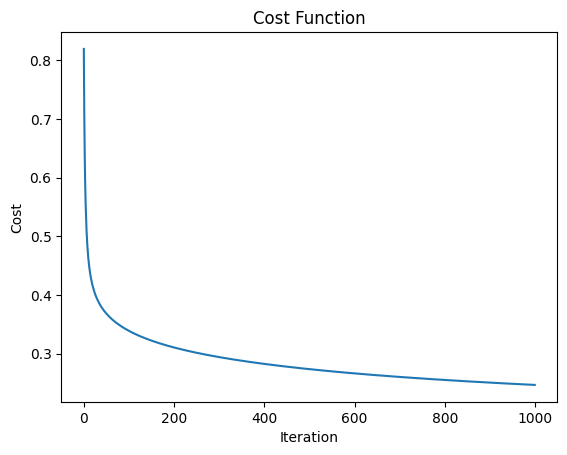

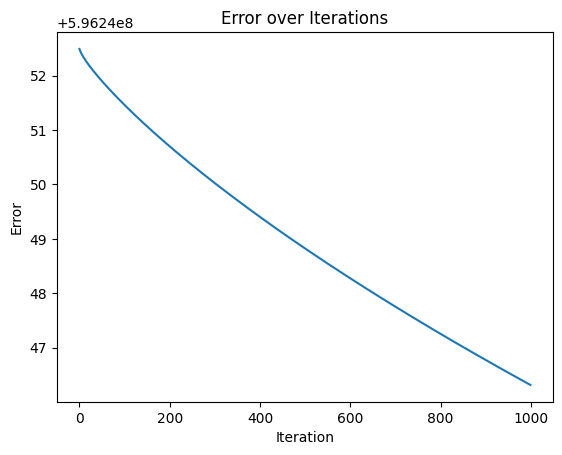

In [21]:
numIterations = 1000
mu = 0.01
# ============================================================================
N = X.shape[1]  # Number of training samples
p = X.shape[0]  # Number of features (784 for MNIST)
num_classes = 10

W = np.zeros((num_classes, p))

#Initialize arrays
cost = []
error = []

# Closed-form solution
W_star = np.dot(Y_train, np.linalg.pinv(X))

for k in range(numIterations):
    #Compute Cost
    gradient = np.dot((Y_train - np.dot(W, X)), X.T) * (2 / N)
    W = W + mu * gradient
    #Compute Cost
    co = np.linalg.norm(Y_train - np.dot(W, X), 'fro')**2 / N
    cost.append(co)

    # Compute error
    err = np.linalg.norm(W_star - W, 'fro')**2
    error.append(err)

plt.figure()
plt.plot(cost)
plt.title('Cost Function')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

plt.figure()
plt.plot(error)
plt.title('Error over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

# ============================================================================


**Exercise 3 [30 points]**
 * Reimplement the algorithm from the previous exercise but now use PyTorch taking advantage of its automatic differentiation feature that will compute the gradients for you. Go to the [PyTorch tutorials](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) page in order to learn how to manipulate tensors with autograd. You can use random initialization for the weights $\boldsymbol W^{(0)}$ [20 points]
 * Plot the evolution of the cost function over the iterations [5 points]
 * Plot the difference (error) between your current estimate and the optimal estimate $\lVert \boldsymbol W^\star - \boldsymbol W^{(k)} \rVert_F^2$ over the iterations [5 points]

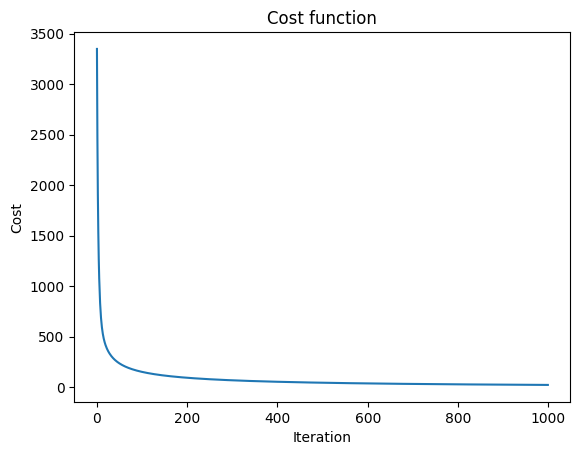

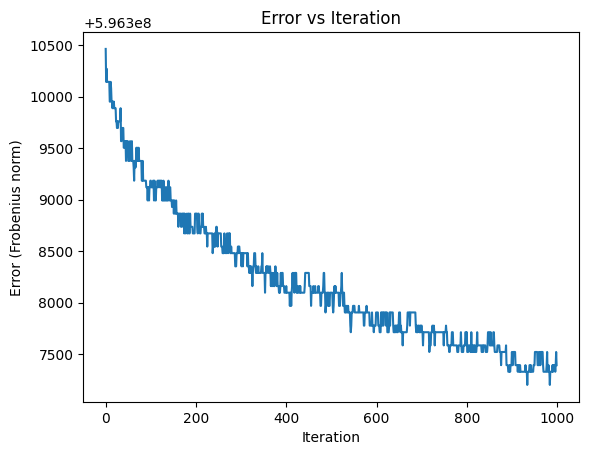

In [22]:
numIterations = 1000
stepSize = 0.01

# ============================================================================
X_train_torch = torch.tensor(X, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float32)

# Random initialization of weights W(0) with requires_grad=True for autograd
W = torch.randn((num_classes, p), dtype=torch.float32, requires_grad=True)

# Initialize lists
cost = []
error = []

# Calculate W*
W_star = torch.tensor(np.dot(Y_train, np.linalg.pinv(X)), dtype=torch.float32)

# ============================================================================
# Convert data to torch tensors

for k in range(numIterations):
    Y_pred = W @ X_train_torch
    # Compute loss (MSE)
    loss = torch.norm(Y_train_torch - Y_pred, p='fro')**2 / N_train
    cost.append(loss.item())
    # Backpropagation
    loss.backward()
    with torch.no_grad():
        W -= stepSize * W.grad
        W.grad.zero_()

    # Calculate Frobenius norm
    err = torch.norm(W_star - W, p='fro')**2
    error.append(err.item())

#Plot cost and error
plt.plot(cost)
plt.title('Cost function')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

plt.plot(error)
plt.title('Error vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Error (Frobenius norm)')
plt.show()

**Exercise 4 [30 points]**

We have given you code for a **Convolutional Neural Network (CNN)** which is a huge improvement over the previous methods since [it considers spatial information](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) and takes advantage of a Neural Network arcitecure which simulates structures found in the brain.  Basic CNNs are usually divided into two parts, *feature extraction layers* in which most parameters are stored in the form of **kernels** which are the **impulse responses** to specific image features. The advantage of this approach is that a CNN is **shift-invariant** meaning that it will still be able to recognize a the number 3 even if it has been shifted to a differnt location in the input image.  This is followed by a *fully-connected* linear layer in which extracted features are combined to generate the output.  We have given you a CNN `model` below.  Since it has an interior convolutional layer this is an example of **Deep Learning**.  A more detailed discussion of how this works is beyond the scope of this course.  

In [23]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Initialize feature extraction layers
        self.fe = nn.Sequential(nn.Conv2d(1,16,5), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.1),
                                nn.Conv2d(16,32,5), nn.ReLU(), nn.MaxPool2d(2) )

        # Initilize fully-connected layer
        self.fc = nn.Linear(512,10) # Convert 512 learned features to 10 outputs

    def forward(self, x):
        # Evaluate model
        x = self.fe(x)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        output = self.fc(x)
        return output

model = CNN()

* Use the *Stocastic Gradient Descent* `optimizer` and *Cross Entropy* `lossFunction` to optimize CNN parameters on training dataset.  You probably need at least 200 iterations [20 points]
* Plot the evolution of the cost function over the iterations [5 points]

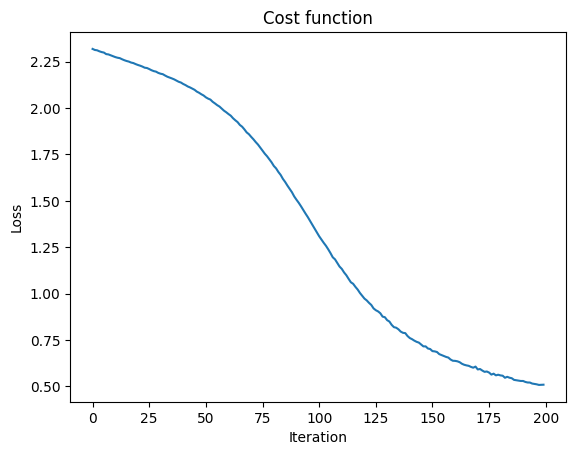

In [24]:
x = images.float() # Images from training dataset
y = nn.functional.one_hot(labels).float() # One-hot labels from training dataset

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
lossFunction = nn.CrossEntropyLoss()
numIterations = 200

#Initialize list of losses
loss_list = []
for iteration in range(numIterations):

   # Update optimizer using step() method and clear gradient using zero_grad() method
    optimizer.zero_grad()
    # Use CNN model to predict one-hot labels y
    pred = model(x)

    # Evaluate lossFunction on model prediction and original one-hot labels y.  Then back propagate error using backward() method
    loss = lossFunction(pred, y)

    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())

#Plot losses
plt.plot(loss_list)
plt.title('Cost function')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()




* Display the accuracy of model on test data [5 points]

In [25]:
x_test = test_images.float() # Images from training dataset
y_test = nn.functional.one_hot(test_labels).float() # One-hot labels from training dataset
c_test = np.argmax(y_test.detach().numpy(),1)

model.eval()

# Forward pass: Predict class probabilities on the test data
with torch.no_grad():
    output_test = model(x_test)

# Get the label with the hgihest probability determined by max vlaue
predicted_labels = torch.argmax(output_test, dim=1)

# convert to tensor
true_labels = torch.tensor(c_test)

# calculate accuracy
sum = (predicted_labels == true_labels).sum().item()
total = true_labels.size(0)
acc = sum / total * 100
print(acc)


79.0
